[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cadCAD-org/demos/blob/master/tutorials/robots_and_marbles/robot-marbles-part-1/robot-marbles-part-1.ipynb)

# cadCAD Tutorials: The Robot and the Marbles, part 1


## What is cadCAD?
cadCAD is a Python library that assists in the processes of designing, testing and validating complex systems through simulation. At its core, cadCAD is a differential games engine that supports parameter sweeping and Monte Carlo analyses and can be easily integrated with other scientific computing Python modules and data science workflows.

At [BlockScience](http://bit.ly/github_articles_M_1), we've been using cadCAD as a tool for [Token Engineering](https://medium.com/block-science/on-the-practice-of-token-engineering-part-i-c2cc2434e727) - the design of self-organizing systems enabled through cryptographic peer-to-peer networks. But cadCAD can simulate any system that can be described as state variables that evolve over time according to a set of equations. This series of articles will go over the basic concepts of cadCAD and the 'language' in which a system must be described in order for it to be interpretable by the library. This article will cover the following concepts:
* State Variables
* Timestep
* State Update Functions
* Partial State Update Blocks
* Simulation Configuration Parameters

## How to install cadCAD
You can use pip to install cadCAD and the other libraries used in this notebook. Uncomment the following line to install the required libraries. This will be necessary even if you are running this notebook on Google Colab

In [1]:
%%capture
# Only run this cell if you need to install the libraries
# If running in google colab, this is needed.

!pip install cadcad matplotlib pandas numpy


## Tutorial

To help illustrate, we'll refer to a simple example system

__The robot and the marbles__  
* Picture a box (`box_A`) with ten marbles in it; an empty box (`box_B`) next to the first one; and a robot arm capable of taking a marble from any one of the boxes and dropping it into the other one. 
* The robot is programmed to take one marble at a time from the box containing the largest number of marbles and drop it in the other box. It repeats that process until the boxes contain an equal number of marbles.  

## State Variables
>A state variable is one of the set of variables that are used to describe the mathematical "state" of a dynamical system. Intuitively, the state of a system describes enough about the system to determine its future behaviour in the absence of any external forces affecting the system. [_(source: Wikipedia)_](https://en.wikipedia.org/wiki/State_variable)

cadCAD can handle state variables of any Python data type, including custom classes. It is up to the user of cadCAD to determine the state variables needed to sufficiently accurately describe the system they are interested in.

We could describe the simple system in our example with only two state variables: the number of marbles in `box_A` and in `box_B`. These are not the only two variables that describe the system, of course. Things like the position of the robot arm in space or its temperature also qualify as "variables that describe the state of the system". But if we assume those variables have no impact on the behavior of the system (as implied by the description) we can safely disregard them.

cadCAD expects state variables to be passed to it as a Python `dict` where the `dict_keys` are the __names of the 
variables__ and the `dict_values` are their __initial values__.

In [2]:
initial_state = {
    'box_A': 10, # box_A starts out with 10 marbles in it
    'box_B': 0 # box_B starts out empty
}

## Dependencies

In [3]:
# Data processing and plotting libraries
import pandas as pd
import numpy as np
from random import normalvariate
import matplotlib.pyplot as plt

# cadCAD specific libraries
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD.engine import ExecutionContext, Executor

# Timestep
Computer simulations run in discrete time:
>Discrete time views values of variables as occurring at distinct, separate "points in time", or equivalently as being unchanged throughout each non-zero region of time ("time period")—that is, time is viewed as a discrete variable. Thus a non-time variable jumps from one value to another as time moves from one time period to the next. This view of time corresponds to a digital clock that gives a fixed reading of 10:37 for a while, and then jumps to a new fixed reading of 10:38, etc. [_(source: Wikipedia)_](https://en.wikipedia.org/wiki/Discrete_time_and_continuous_time)

The concept of Timestep in cadCAD refers to a discrete unit of time. cadCAD increments a "time counter", and at each step it updates the state variables according to the equations that describe the system. If time itself is a state variable that the user is interested in keeping track of, they may specify a state update function that models the passing of time. We'll cover that scenario in an upcoming article. For the moment, it suffices to define that the robot acts once per timestep.

# State Update Functions
State Update Functions are Python functions that represent the equations according to which the state variables change over time. Each state update function must return a __single__ tuple containing the name of the state variable being updated and its new value. Each State Update Function can only update __one__ state variable. The general structure of a state update function is:
```python
def s_function(params, substep, state_history, previous_state, policy_input):
    # Parameters & variables
    ...
    
    # Logic
    new_value = ...
    
    # Output
    return ('state_variable_name', new_value)
```
The convention for __State Update Functions__ is to start the function name with __'s_'__ (for __*s*__tate), followed by the name of the __State Variable__ that it is altering. 
>__Example:__ Imagine you have a `State Variable` called `temperature`. The State Update Function name would be: `s_temperature`.

> __Note__: This is merely a naming convention and does __NOT__ relate to any mechanics under the hood of cadCAD.

State update functions can read the current state of the system from argument `previous_state`. We'll ignore the other arguments for now. `previous_state` is a Python `dict` where the `dict_keys` are the __names of the variables__ and the `dict_values` are their __current values__. With this, we can define the state update functions for variables `box_A` and `box_B`.


In [4]:
def s_box_A(params, substep, state_history,  previous_state, policy_input):
    # Parameters & variables
    box_a = previous_state['box_A']
    box_b = previous_state['box_B']
    
    # Logic
    if box_b > box_a:
        b_to_a = 1
    elif box_b < box_a:
        b_to_a = -1
    else:
        b_to_a = 0
           
    box_A_new = box_a + b_to_a
    
    # Output
    return ('box_A', box_A_new)


def s_box_B(params, substep, state_history, previous_state, policy_input):
    # Parameters & variables
    box_a = previous_state['box_A']
    box_b = previous_state['box_B']
    
    # Logic
    if box_b > box_a:
        b_to_a = 1
    elif box_b < box_a:
        b_to_a = -1
    else:
        b_to_a = 0
          
    box_B_new = box_b - b_to_a
  
    # Output
    return ('box_B', box_B_new)

# Partial State Update Blocks
Within a timestep, state update functions can be run in any combination of serial or parallel executions. Take the following diagram for example:
<center><img src="partial-state-update-blocks.png" alt="Partial State Update Blocks" width="60%"/></center>
<center><b>Figure 1: Visual representation of Partial State Update Blocks</b></center>

State update functions (SUF) 1 and 2 are run in parallel. This means that if SUF2 reads the value of variable A, it will not get the value updated by SUF1. On the other hand, SUF3 and SUF4 are executed after SUF1 and SUF2 have completed, thus having access to the updated values of variables A and C.

We refer to the groups of state update functions that are executed in parallel within a timestep as Partial State Update Blocks. cadCAD expects partial state update blocks to be specified as a list of `dict`s with the following structure:
```python
partial_state_update_blocks = [
    { 
        'label': 'First PSUB',
        'policies': {
            'policy_1': p_function_1, # Policy update functions, ignore for now
            'policy_2': p_function_2,
            ...
        },
        'variables': { # 'variables' refers to the State Variables defined in initial_state 
            'state_variable_1': s_function_1, # State update functions
            'state_variable_2': s_function_2,
            ...
        }
    },
    { 
        'label': 'Second PSUB',
        'policies': {
            'policy_3': p_function_3, # Policy update functions, ignore for now
            'policy_4': p_function_4,
            ...
        },
        'variables': {
            'state_variable_3': s_function_3, # State update functions
            'state_variable_4': s_function_4,
            ...
        }
    },
    ...
]
```

We'll ignore the `policies` key for now. The `dict` that represents the structure of Figure 1 would be:
```python
partial_state_update_blocks = [
    { 
        'label': 'Partial State Update Block 1',
        'policies': {
        },
        'variables': {
            'variable_A': s_function_1,
            'variable_C': s_function_2,
        }
    },
    { 
        'label': 'Partial State Update Block 2',
        'policies': {
        },
        'variables': {
            'variable_A': s_function_3,
            'variable_B': s_function_4,
        }
    }
]
```

In the case of our robot and marbles example system, we can model the system so that all state update functions are executed in parallel. In other words, we consider the marbles move from one box to the other simultaneously (ie, `box_A + box_B` is constant)

In [5]:
partial_state_update_blocks = [
    { 
        'label': 'Marble Update',
        'policies': { # We'll ignore policies for now
        },
        'variables': { # The following state variables will be updated simultaneously
            'box_A': s_box_A,
            'box_B': s_box_B
        }
    }
]

# Simulation Configuration Parameters
Lastly, we define the number of timesteps and the number of Monte Carlo runs of the simulation. These parameters must be passed in a dictionary, in `dict_keys` `T` and `N`, respectively. In our example, we'll run the simulation for 10 timesteps. And because we are dealing with a deterministic system, it makes no sense to have multiple Monte Carlo runs, so we set `N=1`. We'll ignore the `M` key for now and set it to an empty `dict`

In [6]:
MONTE_CARLO_RUNS = 1
SIMULATION_TIMESTEPS = 10

sim_config = config_sim(
    {
        'N': MONTE_CARLO_RUNS,
        'T': range(SIMULATION_TIMESTEPS),
        #'M': {} # This will be explained in later tutorials
    }
)

## Configs
cadCAD stores the configuration for the experiments in a global configs object. To ensure we start fresh, we need to empty the configs object.

In [7]:
from cadCAD import configs
del configs[:]

# Putting it all together
We have defined the state variables of our system and their initial conditions, as well as the state update functions, which have been grouped in a single state update block. We have also specified the parameters of the simulation (number of timesteps and runs). We are now ready to put all those pieces together in a `Configuration` object.

In [8]:
experiment = Experiment()

experiment.append_configs(
    sim_configs=sim_config,
    initial_state=initial_state,
    partial_state_update_blocks=partial_state_update_blocks,
)

# Running the engine
We are now ready to run the engine with the configuration defined above. Instantiate an ExecutionMode, an ExecutionContext and an Executor objects, passing the Configuration object to the latter. Then run the `execute()` method of the Executor object, which returns the results of the experiment in the first element of a tuple.

In [9]:
exec_context = ExecutionContext()
run = Executor(exec_context=exec_context, configs=configs)

(system_events, tensor_field, sessions) = run.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (10, 1, 1, 2)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 0.02s


# Analyzing the results
We can now convert the raw results into a pandas DataFrame for analysis

In [10]:
df = pd.DataFrame(system_events)
df.set_index(['simulation', 'run', 'timestep', 'substep'])

box_A  box_B  subset
simulation run timestep substep                      
0          1   0        0           10      0       0
               1        1            9      1       0
               2        1            8      2       0
               3        1            7      3       0
               4        1            6      4       0
               5        1            5      5       0
               6        1            5      5       0
               7        1            5      5       0
               8        1            5      5       0
               9        1            5      5       0
               10       1            5      5       0

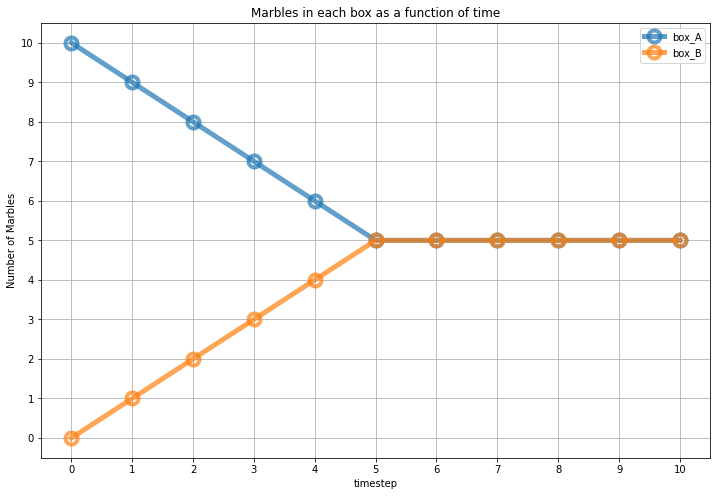

In [11]:
# Create figure

fig = df.plot(x='timestep', y=['box_A','box_B'], marker='o', markersize=12,
                markeredgewidth=4, alpha=0.7, markerfacecolor='black',
                linewidth=5, figsize=(12,8),  title="Marbles in each box as a function of time", 
                ylabel='Number of Marbles', grid=True, fillstyle='none',  
                xticks=list(df['timestep'].drop_duplicates()),
                yticks=list(range(1+(df['box_A']+df['box_B']).max()))                );

Because the number of marbles in the system is even, it converges to an equilibrium with 5 marbles in each box. Simulating a scenario with an odd number of marbles is as easy as modifying the `initial_condition` of the system, recreating the configuration object and rerunning the simulation:

In [12]:
initial_state = {
    'box_A': 11, # box_A starts out with 10 marbles in it
    'box_B': 0 # box_B starts out empty
}

experiment = Experiment()
del configs[:]

experiment.append_configs(
    sim_configs=sim_config,
    initial_state=initial_state,
    partial_state_update_blocks=partial_state_update_blocks,
)

run = Executor(exec_context=exec_context, configs=configs)

(system_events, tensor_field, sessions) = run.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (10, 1, 1, 2)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 0.00s


In [13]:
df = pd.DataFrame(system_events)
df.set_index(['simulation', 'run', 'timestep', 'substep'])

box_A  box_B  subset
simulation run timestep substep                      
0          1   0        0           11      0       0
               1        1           10      1       0
               2        1            9      2       0
               3        1            8      3       0
               4        1            7      4       0
               5        1            6      5       0
               6        1            5      6       0
               7        1            6      5       0
               8        1            5      6       0
               9        1            6      5       0
               10       1            5      6       0

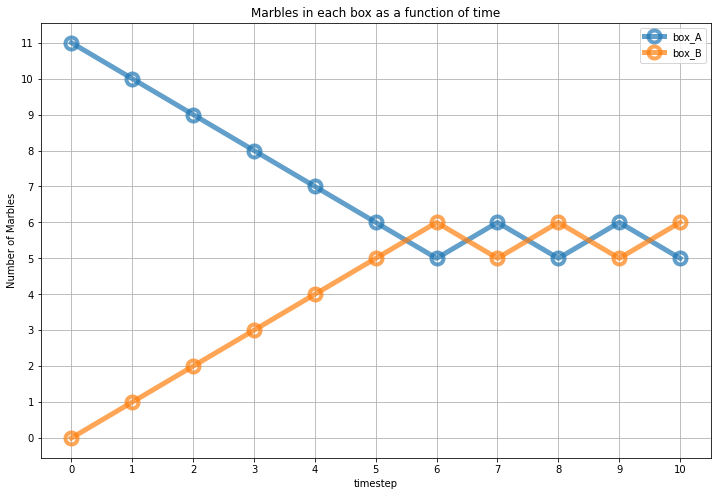

In [14]:
# Create figure

fig = df.plot(x='timestep', y=['box_A','box_B'], marker='o', markersize=12,
                markeredgewidth=4, alpha=0.7, markerfacecolor='black',
                linewidth=5, figsize=(12,8),  title="Marbles in each box as a function of time", 
                ylabel='Number of Marbles', grid=True, fillstyle='none',  
                xticks=list(df['timestep'].drop_duplicates()),
                yticks=list(range(1+(df['box_A']+df['box_B']).max()))                );

As was to be expected, the system oscilates between 5 and 6 marbles in each box.

In the next article of this series we'll cover another base concept in cadCAD: **policies**.

---

_About BlockScience_  
[BlockScience](http://bit.ly/github_articles_M_1) is a research and engineering firm specialized in complex adaptive systems and applying practical methodologies from engineering design, development and testing to projects in emerging technologies such as blockchain. Follow us on [Medium](http://bit.ly/bsci-medium) or [Twitter](http://bit.ly/bsci-twitter) to stay in touch.